# Iberdrola Project - Phase 2 [Occupancy Detection]

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print(torch.__version__)

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: NVIDIA GeForce RTX 3080 Ti Laptop GPU
GPU Capability: (8, 6)
Is GPU Initialized yet? True
2.1.2+cu121


# Import Libraries

In [2]:
import os
import h5py
import scipy
import random
import pickle
import json
import configparser
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.io import loadmat, savemat
from pathlib import Path
from tqdm import tqdm
from scipy.stats import pearsonr

In [3]:
%matplotlib inline
sns.set_style('white')

# Import and Prepare Data

## Prepare Dataset for Training

Import Data

In [4]:
fl_Data = h5py.File(os.path.join('Raw_Data/Phase_2_Exp_1/Smart_Meter_Data_Matched_Occupancy.mat'), 'r')
fl_Data.keys()

<KeysViewHDF5 ['data_occupancy', 'data_sm', 'house_number_array']>

Extract Data

In [5]:
X_Data = np.swapaxes(np.array(fl_Data['data_sm']), 1, 2)
Y_Data = np.expand_dims(np.array(fl_Data['data_occupancy']), axis=2)
house_labels = np.int_(np.transpose(np.array(fl_Data['house_number_array'])))
print(X_Data.shape)
print(Y_Data.shape)
print(house_labels.shape)

(449, 86400, 16)
(449, 86400, 1)
(449, 1)


Create Folds - Train and Test Sets - 20% from Each House in the Test Set

In [6]:
# Configurations
segment_length = 86400
num_channels = 16
house_labels_unique = np.int_(np.unique(house_labels))
print(house_labels_unique)
X_Train = np.zeros((1000,segment_length,num_channels))
Y_Train = np.zeros((1000,segment_length,1), dtype=int)
X_Test = np.zeros((1000,segment_length,num_channels))
Y_Test = np.zeros((1000,segment_length,1), dtype=int)
train_counter = 0
test_counter = 0
for i in house_labels_unique:
    Current_House_Indices = np.where(house_labels == i)[0]
    X_Data_Current_House = np.take(X_Data, Current_House_Indices, axis=0)
    Y_Data_Current_House = np.take(Y_Data, Current_House_Indices, axis=0)
    if (X_Data_Current_House.shape[0] < 5 or Y_Data_Current_House.shape[0] < 5):
        continue
    X_Train_Temp, X_Test_Temp, Y_Train_Temp, Y_Test_Temp = train_test_split(X_Data_Current_House, Y_Data_Current_House, test_size=0.2, random_state=0)
    X_Train_shape = np.shape(X_Train_Temp)
    X_Test_shape = np.shape(X_Test_Temp)
    X_Train[train_counter:train_counter+X_Train_shape[0],:,:] = X_Train_Temp
    Y_Train[train_counter:train_counter+X_Train_shape[0],:,:] = Y_Train_Temp
    X_Test[test_counter:test_counter+X_Test_shape[0],:,:] = X_Test_Temp
    Y_Test[test_counter:test_counter+X_Test_shape[0],:,:] = Y_Test_Temp
    train_counter = train_counter + X_Train_shape[0]
    test_counter = test_counter + X_Test_shape[0]
X_Train1 = np.array(X_Train[0:train_counter,:,:])
Y_Train1 = np.array(Y_Train[0:train_counter,:,:])
X_Test = np.array(X_Test[0:test_counter,:,:])
Y_Test = np.array(Y_Test[0:test_counter,:,:])
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_Train1, Y_Train1, test_size=0.1, random_state=0)
X_Train = X_Train1
Y_Train = Y_Train1
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)
print(X_Val.shape)
print(Y_Val.shape)

[1 2 3 4 5]
(357, 86400, 16)
(357, 86400, 1)
(92, 86400, 16)
(92, 86400, 1)
(36, 86400, 16)
(36, 86400, 1)


Overlap Train Set

In [7]:
# Overlap
X_Data_Shape = X_Train.shape
Y_Data_Shape = Y_Train.shape
segment_length = X_Data_Shape[1]
print(X_Data_Shape)
print(Y_Data_Shape)
# Reshape Array
X_Data_Reshaped = np.reshape(X_Train, (X_Data_Shape[0]*X_Data_Shape[1], num_channels))
Y_Data_Reshaped = np.reshape(Y_Train, (Y_Data_Shape[0]*Y_Data_Shape[1], 1))
X_Data_Reshaped_Shape = X_Data_Reshaped.shape
Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
print(X_Data_Reshaped_Shape)
print(Y_Data_Reshaped_Shape)
# Overlap
overlap_ratio = 0.75
offset_amount = np.int_(segment_length*(1 - overlap_ratio))
X_Data_New = np.zeros((2000,segment_length,num_channels))
Y_Data_New = np.zeros((2000,segment_length,1))
num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/offset_amount))
counter = 0
for i in range(0,num_segments_approx):
    if (i*offset_amount+segment_length) > X_Data_Reshaped_Shape[0]:
        continue
    X_Data_Temp = X_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
    X_Data_New[counter,:,:] = X_Data_Temp
    Y_Data_Temp = Y_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
    Y_Data_New[counter,:,:] = Y_Data_Temp
    counter = counter + 1
X_Train_OVRL = X_Data_New[0:counter,:,:]
Y_Train_OVRL = Y_Data_New[0:counter,:,:]
print(X_Train_OVRL.shape)
print(Y_Train_OVRL.shape)

(357, 86400, 16)
(357, 86400, 1)
(30844800, 16)
(30844800, 1)
(1425, 86400, 16)
(1425, 86400, 1)


Transform Labels for Classification

In [8]:
def transform_labels(X_Data_OVRL, Y_Data_OVRL, segment_length, num_channels):
    X_Data_New = np.zeros((20000,num_channels,segment_length))
    Y_Data_New = np.zeros((20000,1), dtype=int)
    ## Raw Dataset
    X_Data_Shape = X_Data_OVRL.shape
    Y_Data_Shape = Y_Data_OVRL.shape
    # Reshape Array
    X_Data_Reshaped = np.reshape(X_Data_OVRL, (X_Data_Shape[0]*X_Data_Shape[1], num_channels))
    Y_Data_Reshaped = np.reshape(Y_Data_OVRL, (Y_Data_Shape[0]*Y_Data_Shape[1], 1))
    X_Data_Reshaped_Shape = X_Data_Reshaped.shape
    Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
    num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/segment_length))
    counter = 0
    for i in range(0,num_segments_approx):
        if ((i+1)*segment_length) > X_Data_Reshaped_Shape[0]:
            continue
        X_Data_Temp = np.transpose(X_Data_Reshaped[i*segment_length:(i+1)*segment_length,:])
        X_Data_Temp_Mean = np.mean(X_Data_Temp)
        X_Data_Temp_VAR = np.var(X_Data_Temp)
        X_Data_New[counter,:,:] = X_Data_Temp
        Y_Data_Temp = Y_Data_Reshaped[i*segment_length:(i+1)*segment_length,:]
        Y_Data_Temp_Mean = np.mean(Y_Data_Temp)
        Y_Data_Temp_VAR = np.var(Y_Data_Temp)
        Y_Data_Temp_SUM = np.sum(Y_Data_Temp)
        if X_Data_Temp_VAR <= 0.001:
            continue
        # if Y_Data_Temp_VAR <= 0.001:
            # continue
        if (Y_Data_Temp_SUM < np.round(0.05*segment_length)) or (Y_Data_Temp_SUM > np.round(0.95*segment_length)):
            continue
        # if Y_Data_Temp_SUM == segment_length:
            # continue
        if Y_Data_Temp_Mean > 0.5:
            Y_Label = 1
        else:
            Y_Label = 0
        Y_Data_New[counter,:] = Y_Label
        counter = counter + 1
    X_Data_New = X_Data_New[0:counter,:,:]
    Y_Data_New = Y_Data_New[0:counter,:]
    return X_Data_New, Y_Data_New

In [9]:
segment_length = 1200  # 20 Minutes = 1200 Data Points (1 Hz sampling rate)
num_channels = 16
X_Train_C, Y_Train_C = transform_labels(X_Train_OVRL, Y_Train_OVRL, segment_length, num_channels)
X_Test_C, Y_Test_C = transform_labels(X_Test, Y_Test, segment_length, num_channels)
X_Val_C, Y_Val_C = transform_labels(X_Val, Y_Val, segment_length, num_channels)
print(X_Train_C.shape)
print(Y_Train_C.shape)
print(X_Test_C.shape)
print(Y_Test_C.shape)
print(X_Val_C.shape)
print(Y_Val_C.shape)
labels, counts = np.unique(Y_Train_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Y_Test_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Y_Val_C, return_counts=True)
print(labels, counts)


(2422, 16, 1200)
(2422, 1)
(163, 16, 1200)
(163, 1)
(62, 16, 1200)
(62, 1)
[0 1] [1192 1230]
[0 1] [77 86]
[0 1] [28 34]


Balance train set (if required)

In [10]:
Y_Train_0_indices = np.where(Y_Train_C == 0)[0]
X_Train_C_0 = np.take(X_Train_C, Y_Train_0_indices, axis=0)
Y_Train_C_0 = np.take(Y_Train_C, Y_Train_0_indices, axis=0)
Y_Train_1_indices = np.where(Y_Train_C == 1)[0]
X_Train_C_1 = np.take(X_Train_C, Y_Train_1_indices, axis=0)
Y_Train_C_1 = np.take(Y_Train_C, Y_Train_1_indices, axis=0)
#
Y_Train_C_0_shape = Y_Train_C_0.shape
Y_Train_C_1_shape = Y_Train_C_1.shape
Y_Train_C_shape = Y_Train_C.shape
if Y_Train_C_1_shape[0] > Y_Train_C_0_shape[0]:
    index = np.random.choice(Y_Train_C_1_shape[0], Y_Train_C_0_shape[0], replace=False)
    X_Train_1 = X_Train_C_1[index]
    Y_Train_1 = Y_Train_C_1[index]
    X_Train = np.concatenate([X_Train_C_0, X_Train_1], axis=0)
    Y_Train = np.concatenate([Y_Train_C_0, Y_Train_1], axis=0)
elif Y_Train_C_0_shape[0] > Y_Train_C_1_shape[0]:
    index = np.random.choice(Y_Train_C_0_shape[0], Y_Train_C_1_shape[0], replace=False)
    X_Train_0 = X_Train_C_0[index]
    Y_Train_0 = Y_Train_C_0[index]
    X_Train = np.concatenate([X_Train_C_1, X_Train_0], axis=0)
    Y_Train = np.concatenate([Y_Train_C_1, Y_Train_0], axis=0)
#
X_Train_C = X_Train
Y_Train_C = Y_Train
print(X_Train_C.shape)
print(Y_Train_C.shape)

(2384, 16, 1200)
(2384, 1)


Test - Plot

[0.02546683 0.02546683 0.02543566 ... 0.00604538 0.00600607 0.0060291 ]


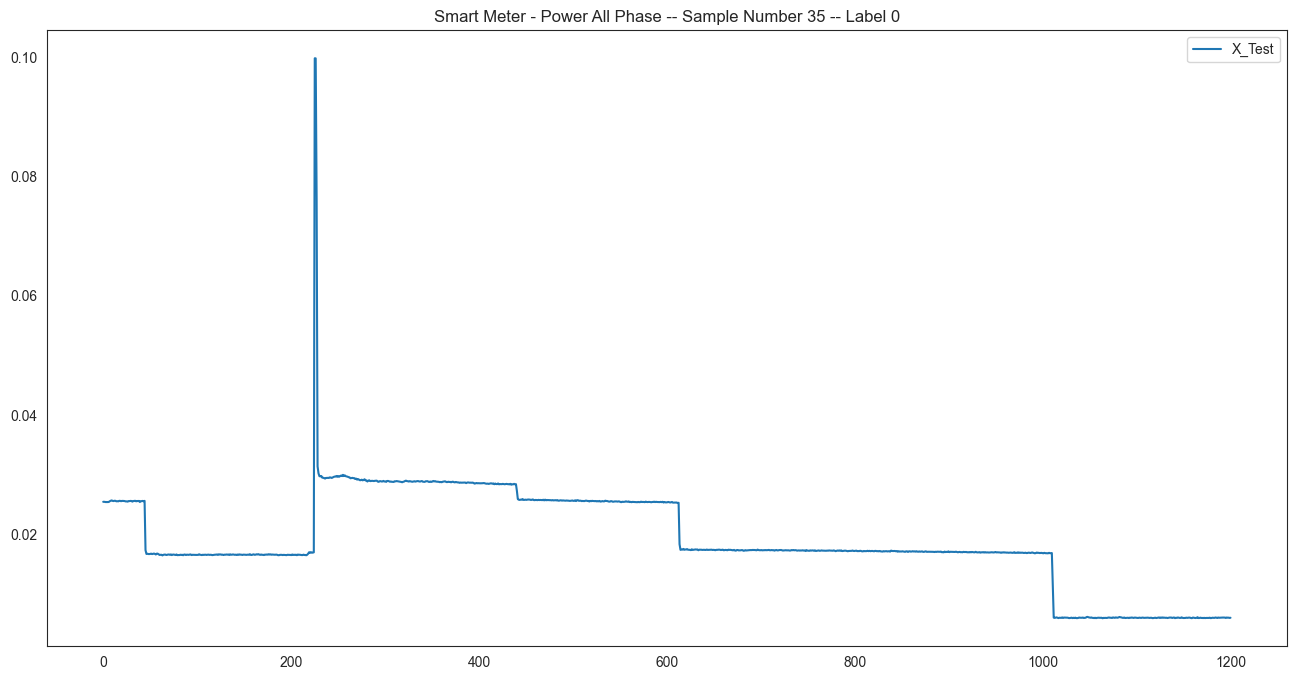

In [11]:
data_shape = Y_Test_C.shape
sm_channel = 0
j = random.randint(0, data_shape[0])
A = X_Test_C[j,sm_channel,:]
B = Y_Test_C[j,0]
print(A)
plt.figure(figsize=(16, 8))
plt.subplot(1, 1, 1)
plt.plot(A, label='X_Test')
plt.title(f"Smart Meter - Power All Phase -- Sample Number {j} -- Label {B}")
plt.legend()

Save prepared data - all channels

In [10]:
train_data_dic = {"X_Train": X_Train_C,
                  "Y_Train": Y_Train_C,
                  "X_Test": X_Test_C,
                  "Y_Test": Y_Test_C,
                  "X_Val": X_Test_C,
                  "Y_Val": Y_Test_C,
                  }
savemat("Data/Data_Fold_1_All_SM_Channels.mat", train_data_dic, format='5')

Load prepared data, select channels and save for the pipeline

In [32]:
data = loadmat('Data/Data_Fold_1_All_SM_Channels.mat')
X_Train = data['X_Train']
Y_Train = data['Y_Train']
X_Test = data['X_Test']
Y_Test = data['Y_Test']
X_Val = data['X_Val']
Y_Val = data['Y_Val']
#
selected_channels = [1]
X_Train = X_Train[:,selected_channels,:]
X_Test = X_Test[:,selected_channels,:]
X_Val = X_Val[:,selected_channels,:]

X_Train = np.where(X_Train==np.nan, 0, X_Train)
X_Test = np.where(X_Test==np.nan, 0, X_Test)
X_Val = np.where(X_Val==np.nan, 0, X_Val)
#
train_data_dic = {"X_Train": X_Train,
                  "Y_Train": Y_Train,
                  "X_Test": X_Test,
                  "Y_Test": Y_Test,
                  "X_Val": X_Val,
                  "Y_Val": Y_Val,
                  }
savemat("Data/Data_Fold_1.mat", train_data_dic, format='5')

Garbage Collector

In [ ]:
import gc #Garbage Collector
fl_Data = None
X_Test = None
X_Train = None
X_Val = None
Y_Test = None
Y_Train = None
Y_Val = None
gc.collect()

0

# MAIN

## Configurations

In [33]:
# CREATE OBJECT
config_file = configparser.ConfigParser()
# ADD NEW SECTION AND SETTINGS
config_file["TRAIN"] = {
    'parentdir': '',  # Root or Parent Directory
    'datafile': 'Data',  # Folder containing the dataset
    'val_size': 0.0,  # Validation percentage for splitting
    'q_order': 3,  # q-order for the Self-ONN or Super-ONN Models
    'batch_size': 4,  # Batch Size, Change to fit hardware
    'lossType': 'SoftM_MSE',  # loss function: 'SoftM_CELoss' or 'SoftM_MSE' or 'MSE'
    'optim_fc': 'Adam',  # 'Adam' or 'SGD'
    'lr': 0.0005,  # learning rate
    'stop_criteria': 'accuracy',  # Stopping criteria: 'loss' or 'accuracy'
    'n_epochs': 500,  # number of training epochs
    'epochs_patience': 8,
    'lr_factor': 0.1,  # lr_factor, if val loss did not decrease for a number of epochs (epochs_patience) then decrease learning rate by a factor of lr_factor
    'max_epochs_stop': 30,  # maximum number of epochs with no improvement in validation loss for early stopping
    'num_folds': 1,  # number of cross validation folds
    'load_model': False,  # load model: True or False
    'load_model_path': 'Results_Classification\RODNet_Occp_Classification\Fold_1\RODNet_Occp_Classification_fold_1.pt',  # specify path of pretrained model wieghts or set to False to train from scratch
    'model_to_load': 'RODNet',  # choose one of the following models: 'CNN_1' 'CNN_2' 'CNN_2' 'CNN_3' 'SelfResNet18' 'ResNet'
    'model_name': 'RODNet_Occp_Classification',  # choose a unique name for result folder
    'aux_logits': False,  # Required for models with auxilliary outputs (e.g., InceptionV3)  
    'fold_start': 1,  # The starting fold for training
    'fold_last': 1,  # The last fold for training
    'results_path': 'Results_Classification',  # main results folder
}

# SAVE CONFIG FILE
with open(r"Config_Train.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()

print("Config file 'Config_Train.ini' created")

Config file 'Config_Train.ini' created


## Train

In [34]:
%run -i Train.py

Train on gpu: True
1 GPUs detected.
Training using RODNet network
Starting training with Fold 1
Shape of Train Data: (2422, 1, 1200)
Shape of Train Label: (2422, 1)
Shape of Validation Data: (163, 1, 1200)
Shape of Validation Label: (163, 1)
Shape of Test Data: (163, 1, 1200)
Shape of Test Label: (163, 1)
Classes: [0 1]
No. of Classes: 2
model device: cuda
Starting Training from Scratch.



Epoch 0: 100%|██████████| 605/605 [00:07<00:00, 77.46it/s]



Epoch: 0 	Training Loss: 0.2501 	Validation Loss: 0.2533 	Test Loss: 0.2533
		Training Accuracy: 52.56%	 Validation Accuracy: 49.69%	 Test Accuracy: 49.69%


Epoch 1: 100%|██████████| 605/605 [00:07<00:00, 78.94it/s]



Epoch: 1 	Training Loss: 0.2494 	Validation Loss: 0.2523 	Test Loss: 0.2523
		Training Accuracy: 52.77%	 Validation Accuracy: 44.79%	 Test Accuracy: 44.79%


Epoch 2: 100%|██████████| 605/605 [00:07<00:00, 79.55it/s]



Epoch: 2 	Training Loss: 0.2465 	Validation Loss: 0.2612 	Test Loss: 0.2612
		Training Accuracy: 55.08%	 Validation Accuracy: 50.92%	 Test Accuracy: 50.92%


Epoch 3: 100%|██████████| 605/605 [00:07<00:00, 80.07it/s]



Epoch: 3 	Training Loss: 0.2444 	Validation Loss: 0.2530 	Test Loss: 0.2530
		Training Accuracy: 57.39%	 Validation Accuracy: 54.60%	 Test Accuracy: 54.60%


Epoch 4: 100%|██████████| 605/605 [00:07<00:00, 80.55it/s]



Epoch: 4 	Training Loss: 0.2388 	Validation Loss: 0.2590 	Test Loss: 0.2590
		Training Accuracy: 58.13%	 Validation Accuracy: 55.83%	 Test Accuracy: 55.83%


Epoch 5: 100%|██████████| 605/605 [00:07<00:00, 81.23it/s]



Epoch: 5 	Training Loss: 0.2336 	Validation Loss: 0.2652 	Test Loss: 0.2652
		Training Accuracy: 61.27%	 Validation Accuracy: 55.21%	 Test Accuracy: 55.21%


Epoch 6: 100%|██████████| 605/605 [00:07<00:00, 82.78it/s]



Epoch: 6 	Training Loss: 0.2273 	Validation Loss: 0.2779 	Test Loss: 0.2779
		Training Accuracy: 62.26%	 Validation Accuracy: 52.76%	 Test Accuracy: 52.76%


Epoch 7: 100%|██████████| 605/605 [00:07<00:00, 82.02it/s]



Epoch: 7 	Training Loss: 0.2277 	Validation Loss: 0.2824 	Test Loss: 0.2824
		Training Accuracy: 62.39%	 Validation Accuracy: 49.69%	 Test Accuracy: 49.69%


Epoch 8: 100%|██████████| 605/605 [00:07<00:00, 79.67it/s]



Epoch: 8 	Training Loss: 0.2186 	Validation Loss: 0.2822 	Test Loss: 0.2822
		Training Accuracy: 64.66%	 Validation Accuracy: 53.99%	 Test Accuracy: 53.99%


Epoch 9: 100%|██████████| 605/605 [00:07<00:00, 76.67it/s]



Epoch: 9 	Training Loss: 0.2122 	Validation Loss: 0.3051 	Test Loss: 0.3051
		Training Accuracy: 67.18%	 Validation Accuracy: 46.63%	 Test Accuracy: 46.63%


Epoch 10: 100%|██████████| 605/605 [00:07<00:00, 76.88it/s]



Epoch: 10 	Training Loss: 0.2107 	Validation Loss: 0.2640 	Test Loss: 0.2640
		Training Accuracy: 66.93%	 Validation Accuracy: 61.35%	 Test Accuracy: 61.35%


Epoch 11: 100%|██████████| 605/605 [00:07<00:00, 81.99it/s]



Epoch: 11 	Training Loss: 0.1911 	Validation Loss: 0.2897 	Test Loss: 0.2897
		Training Accuracy: 71.55%	 Validation Accuracy: 52.76%	 Test Accuracy: 52.76%


Epoch 12: 100%|██████████| 605/605 [00:07<00:00, 80.31it/s]



Epoch: 12 	Training Loss: 0.1876 	Validation Loss: 0.2736 	Test Loss: 0.2736
		Training Accuracy: 72.21%	 Validation Accuracy: 52.76%	 Test Accuracy: 52.76%


Epoch 13: 100%|██████████| 605/605 [00:07<00:00, 82.12it/s]



Epoch: 13 	Training Loss: 0.1780 	Validation Loss: 0.2880 	Test Loss: 0.2880
		Training Accuracy: 73.78%	 Validation Accuracy: 51.53%	 Test Accuracy: 51.53%


Epoch 14: 100%|██████████| 605/605 [00:07<00:00, 83.21it/s]



Epoch: 14 	Training Loss: 0.1758 	Validation Loss: 0.3014 	Test Loss: 0.3014
		Training Accuracy: 74.32%	 Validation Accuracy: 55.21%	 Test Accuracy: 55.21%


Epoch 15: 100%|██████████| 605/605 [00:07<00:00, 84.48it/s]



Epoch: 15 	Training Loss: 0.1739 	Validation Loss: 0.3156 	Test Loss: 0.3156
		Training Accuracy: 74.69%	 Validation Accuracy: 53.37%	 Test Accuracy: 53.37%


Epoch 16: 100%|██████████| 605/605 [00:07<00:00, 86.26it/s]



Epoch: 16 	Training Loss: 0.1617 	Validation Loss: 0.3056 	Test Loss: 0.3056
		Training Accuracy: 77.09%	 Validation Accuracy: 53.37%	 Test Accuracy: 53.37%


Epoch 17: 100%|██████████| 605/605 [00:07<00:00, 84.55it/s]



Epoch: 17 	Training Loss: 0.1598 	Validation Loss: 0.3007 	Test Loss: 0.3007
		Training Accuracy: 77.70%	 Validation Accuracy: 54.60%	 Test Accuracy: 54.60%


Epoch 18: 100%|██████████| 605/605 [00:07<00:00, 84.37it/s]



Epoch: 18 	Training Loss: 0.1546 	Validation Loss: 0.3257 	Test Loss: 0.3257
		Training Accuracy: 78.45%	 Validation Accuracy: 53.37%	 Test Accuracy: 53.37%


Epoch 19: 100%|██████████| 605/605 [00:07<00:00, 83.34it/s]



Epoch: 19 	Training Loss: 0.1538 	Validation Loss: 0.3227 	Test Loss: 0.3227
		Training Accuracy: 77.83%	 Validation Accuracy: 54.60%	 Test Accuracy: 54.60%


Epoch 20: 100%|██████████| 605/605 [00:07<00:00, 83.83it/s]



Epoch: 20 	Training Loss: 0.1486 	Validation Loss: 0.3035 	Test Loss: 0.3035
		Training Accuracy: 79.27%	 Validation Accuracy: 53.99%	 Test Accuracy: 53.99%


Epoch 21: 100%|██████████| 605/605 [00:07<00:00, 83.81it/s]



Epoch: 21 	Training Loss: 0.1484 	Validation Loss: 0.3101 	Test Loss: 0.3101
		Training Accuracy: 79.11%	 Validation Accuracy: 54.60%	 Test Accuracy: 54.60%


Epoch 22: 100%|██████████| 605/605 [00:07<00:00, 83.89it/s]



Epoch: 22 	Training Loss: 0.1473 	Validation Loss: 0.3179 	Test Loss: 0.3179
		Training Accuracy: 79.81%	 Validation Accuracy: 51.53%	 Test Accuracy: 51.53%


Epoch 23: 100%|██████████| 605/605 [00:07<00:00, 83.62it/s]



Epoch: 23 	Training Loss: 0.1446 	Validation Loss: 0.3165 	Test Loss: 0.3165
		Training Accuracy: 79.52%	 Validation Accuracy: 53.37%	 Test Accuracy: 53.37%


Epoch 24: 100%|██████████| 605/605 [00:07<00:00, 83.00it/s]



Epoch: 24 	Training Loss: 0.1473 	Validation Loss: 0.3123 	Test Loss: 0.3123
		Training Accuracy: 79.19%	 Validation Accuracy: 51.53%	 Test Accuracy: 51.53%


Epoch 25: 100%|██████████| 605/605 [00:07<00:00, 83.39it/s]



Epoch: 25 	Training Loss: 0.1544 	Validation Loss: 0.3264 	Test Loss: 0.3264
		Training Accuracy: 78.08%	 Validation Accuracy: 52.76%	 Test Accuracy: 52.76%


Epoch 26: 100%|██████████| 605/605 [00:07<00:00, 82.08it/s]



Epoch: 26 	Training Loss: 0.1431 	Validation Loss: 0.3077 	Test Loss: 0.3077
		Training Accuracy: 79.56%	 Validation Accuracy: 52.76%	 Test Accuracy: 52.76%


Epoch 27: 100%|██████████| 605/605 [00:07<00:00, 82.86it/s]



Epoch: 27 	Training Loss: 0.1464 	Validation Loss: 0.3180 	Test Loss: 0.3180
		Training Accuracy: 79.64%	 Validation Accuracy: 52.15%	 Test Accuracy: 52.15%


Epoch 28: 100%|██████████| 605/605 [00:07<00:00, 83.63it/s]



Epoch: 28 	Training Loss: 0.1509 	Validation Loss: 0.3264 	Test Loss: 0.3264
		Training Accuracy: 78.20%	 Validation Accuracy: 52.15%	 Test Accuracy: 52.15%


Epoch 29: 100%|██████████| 605/605 [00:07<00:00, 82.08it/s]



Epoch: 29 	Training Loss: 0.1469 	Validation Loss: 0.3219 	Test Loss: 0.3219
		Training Accuracy: 79.36%	 Validation Accuracy: 52.15%	 Test Accuracy: 52.15%


Epoch 30: 100%|██████████| 605/605 [00:07<00:00, 84.13it/s]



Epoch: 30 	Training Loss: 0.1439 	Validation Loss: 0.3024 	Test Loss: 0.3024
		Training Accuracy: 80.18%	 Validation Accuracy: 52.15%	 Test Accuracy: 52.15%


Epoch 31: 100%|██████████| 605/605 [00:07<00:00, 83.70it/s]



Epoch: 31 	Training Loss: 0.1455 	Validation Loss: 0.3191 	Test Loss: 0.3191
		Training Accuracy: 79.36%	 Validation Accuracy: 55.83%	 Test Accuracy: 55.83%


Epoch 32: 100%|██████████| 605/605 [00:07<00:00, 84.68it/s]



Epoch: 32 	Training Loss: 0.1486 	Validation Loss: 0.3112 	Test Loss: 0.3112
		Training Accuracy: 79.77%	 Validation Accuracy: 54.60%	 Test Accuracy: 54.60%


Epoch 33: 100%|██████████| 605/605 [00:07<00:00, 79.52it/s]



Epoch: 33 	Training Loss: 0.1436 	Validation Loss: 0.3219 	Test Loss: 0.3219
		Training Accuracy: 79.89%	 Validation Accuracy: 50.31%	 Test Accuracy: 50.31%


Epoch 34: 100%|██████████| 605/605 [00:07<00:00, 83.65it/s]



Epoch: 34 	Training Loss: 0.1498 	Validation Loss: 0.3079 	Test Loss: 0.3079
		Training Accuracy: 78.86%	 Validation Accuracy: 53.37%	 Test Accuracy: 53.37%


Epoch 35: 100%|██████████| 605/605 [00:07<00:00, 82.60it/s]



Epoch: 35 	Training Loss: 0.1432 	Validation Loss: 0.3063 	Test Loss: 0.3063
		Training Accuracy: 80.18%	 Validation Accuracy: 54.60%	 Test Accuracy: 54.60%


Epoch 36: 100%|██████████| 605/605 [00:07<00:00, 82.50it/s]



Epoch: 36 	Training Loss: 0.1410 	Validation Loss: 0.3219 	Test Loss: 0.3219
		Training Accuracy: 80.39%	 Validation Accuracy: 47.85%	 Test Accuracy: 47.85%


Epoch 37: 100%|██████████| 605/605 [00:07<00:00, 82.90it/s]



Epoch: 37 	Training Loss: 0.1436 	Validation Loss: 0.3090 	Test Loss: 0.3090
		Training Accuracy: 79.27%	 Validation Accuracy: 52.76%	 Test Accuracy: 52.76%


Epoch 38: 100%|██████████| 605/605 [00:07<00:00, 79.24it/s]



Epoch: 38 	Training Loss: 0.1464 	Validation Loss: 0.2964 	Test Loss: 0.2964
		Training Accuracy: 78.82%	 Validation Accuracy: 57.06%	 Test Accuracy: 57.06%


Epoch 39: 100%|██████████| 605/605 [00:07<00:00, 82.44it/s]



Epoch: 39 	Training Loss: 0.1471 	Validation Loss: 0.3116 	Test Loss: 0.3116
		Training Accuracy: 79.07%	 Validation Accuracy: 50.92%	 Test Accuracy: 50.92%


Epoch 40: 100%|██████████| 605/605 [00:07<00:00, 83.20it/s]



Epoch: 40 	Training Loss: 0.1461 	Validation Loss: 0.3222 	Test Loss: 0.3222
		Training Accuracy: 79.64%	 Validation Accuracy: 52.15%	 Test Accuracy: 52.15%

Early Stopping! Total epochs: 40. Best epoch: 10 with loss: 0.26 and acc: 61.35%
315.02 total seconds elapsed. 7.68 seconds per epoch.
Test Loss: 0.264,  Test Accuracy: 61.35%
completed fold 1
#############################################################
Cummulative Confusion Matrix
[[57 20]
 [43 43]]
Overall Test Accuracy: 61.35
#############################################################


## Test

In [35]:
# CREATE OBJECT
config_file = configparser.ConfigParser()
# ADD NEW SECTION AND SETTINGS
config_file["TEST"] = {
    'parentdir': '',  # Root or Parent Directory
    'datafile': 'Data',  # Folder containing the dataset
    'batch_size': 1,  # Batch Size, Change to fit hardware
    'lossType': 'SoftM_MSE',  # loss function: 'SoftM_CELoss' or 'SoftM_MSE' or 'MSE'
    'num_folds': 1,  # number of cross validation folds
    'CI': 0.9,  # Confidence interval (missied cases with probability>=CI will be reported in excel file)
    'load_model': False,  # specify path of pretrained model wieghts or set to False to train from scratch
    'load_model_path': 'Results_Classification\RODNet_Occp_Classification\Fold_1\RODNet_Occp_Classification_fold_1.pt',  # specify path of pretrained model wieghts or set to False to train from scratch
    'labeled_data': True,  # set to true if you have the labeled test set
    'model_name': 'RODNet_Occp_Classification',  # name of the saved model
    'aux_logits': False,  # Required for models with auxilliary outputs (e.g., InceptionV3)  
    'fold_start': 1,  # The starting fold for training
    'fold_last': 1,  # The last fold for training
    'N_steps': 1000,  # The last fold for training
    'results_path': 'Results_Classification',  # main results folder
}
# SAVE CONFIG FILE
with open(r"Config_Test.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()
print("Config file 'Config_Test.ini' created")

Config file 'Config_Test.ini' created


In [36]:
%run -i Test.py

Train on GPU: True
1 GPUs detected.
Combined Evaluation of Folds 1 to 1...
#############################################################
Started fold 1
model device: cuda


Testing:   0%|          | 0/163 [00:00<?, ?it/s]c:\Users\Sakib Mahmud\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Testing: 100%|██████████| 163/163 [00:00<00:00, 182.98it/s]


Test Loss: 0.264,  Test Accuracy: 61.35%
Generating CSV Files from Individual Predictions...
Test Dataframe Write to CSV - Done
Total Inference Time: 4.4 ms
Completed fold 1
#############################################################


Combined Evaluation: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]




    0   1
0  57  20
1  43  43


                  Accuracy  Precision  Sensitivity  F1_score  Specificity
0                    61.35      57.00        74.03     64.41        50.00
1                    61.35      68.25        50.00     57.72        74.03
Weighted Average     61.35      62.94        61.35     60.88        62.68


                       
Overall_Accuracy  61.35


#############################################################
